# Network Architecture Evolution

Evolving the architecture of a convolutional neural network through an advanced directional genetic algorithm known as differential evolution.


## Defining the Differential Evolutionary Algorithm

Differential Evolution is a genetic algorithm which utilizes directional information within a population for creating offspring. Unlike standard genetic algorithms, the 'mutation' operator is applied before the 'crossover' operator. The 'mutation' mechanism is built off creating what is known as the `unit` vector, a vector created from a `target` and `difference` vector. The `target` vector is the direction where the offspring will be created towards, where the `difference` vector is added noise created from the genetic information within the population. Here below we have an exact definition of the `unit` vector:

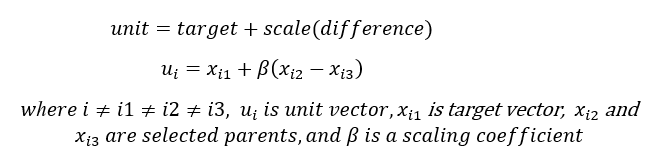

Geometrically speaking, imagine we have three individuals in a 2D domain space, denoted below as $X1,X2,X3$. We can see how the `unit` vector, $U$ is created from the directional information by creating the difference vector from $X2$ and $X3$, scaled by $\beta$, and adding that to the `target` value, $X1$. The `target` value is either chosen to be the best individual of the population, to support good convergence, or a random individual from the population, to support diversity. In the algorithm implemented, random selection is used for choosing the `target`.

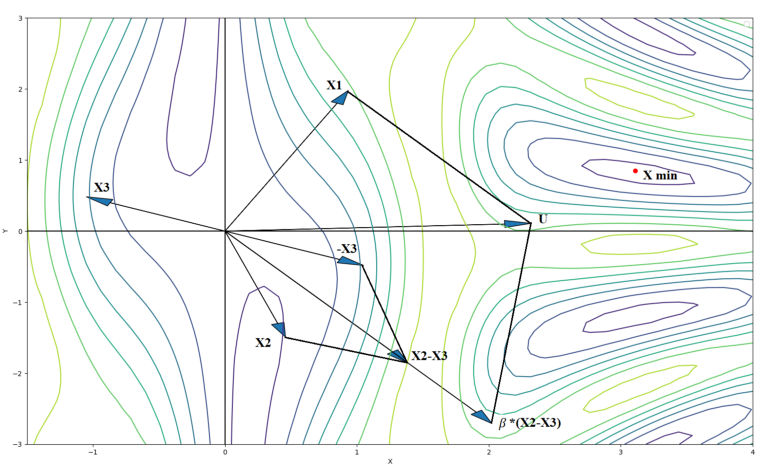

Next, the crossover mechanism is used, either by taking the average between the `unit` vector and the main parent or by swapping variable values. Below is an example of swapped variables values (Note: In the algorithm the average is used)

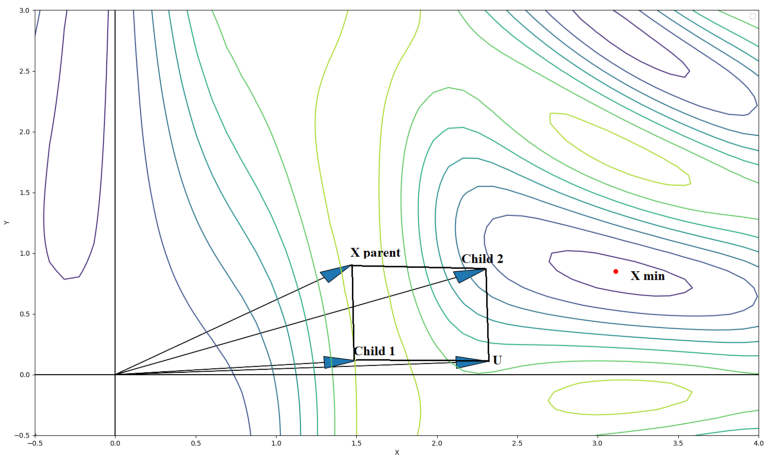

Below, we have a basic diagram of the flow of the differential algorithm:

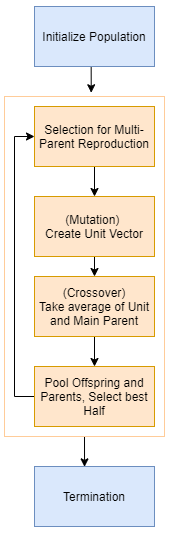

## Defining The Convolution Architecture

The differential algorithm will have the ability to design the architecture of a convolutional neural network through modules. A module is simply a building block that defines which paramters are tunable for the network. 

For example, we might define the convolution part of the network to be built of consecutive modules while the 'deep' network after convolution to be built off a different set of modules. We can stack these modules together to form a tunable convolutional neural network. 

Suppose we define the convolution part of the network to be built off four convolution modules, where each module contains a convolution layer, pooling layer, batch normalization, activation, and dropout:

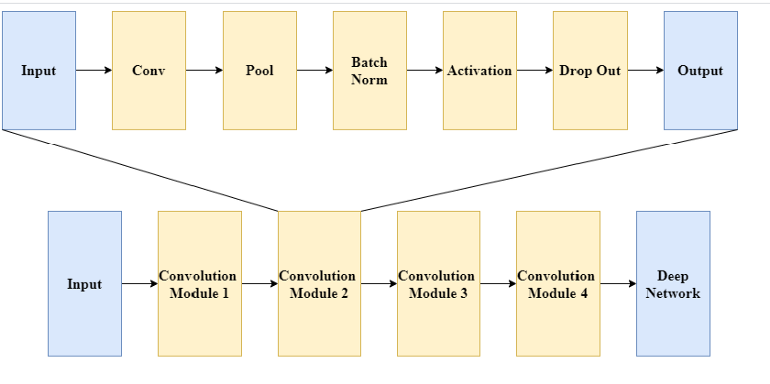

As we can see above, the architecture of the network is built by stacking these modules on top of each other. After defining the modules and the orientation, the differential algorithm will have the ability to select which modules to include, which layers to include within each module, and the hyper-parameter for each layer if chosen. 

The same concept is applied to the 'deep' section of the network, define the deep modules and stack them together:

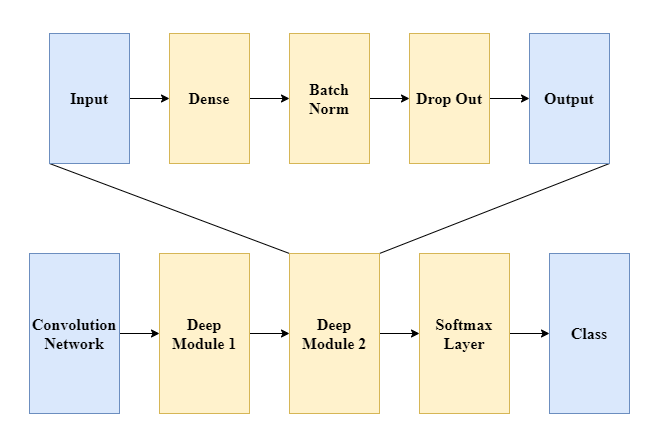

The differential algorithm will again have the ability to choose whether or not to include certain modules, layers within modules, and hyperparamters for each layer. Together, the modules form the architecture of the network:

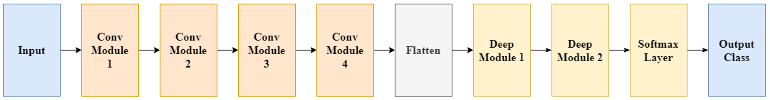

Even though it was shown that the modules were the same for each section, this does not have to be the case.

As of current, the following hyper-parameters for each layer are available to be tuned by the differential algorithm:

| Parameter | Choices  |
| --- | --- |
| Convolution | Number of Output Channels | 
| Pooling | Max or Average |
| Dropout | min_alpha to max_alpha |
| Dense | min_node to max_node |

In addition to the hyper-paramters, the inclusion of each layer and module is available to be tuned by differential algorithm. 

## Other Concerns of the Algorithm

The main problem with optimizing the architecture of a neural network is that each possible solution needs to be trained, which can take anywhere from 15 minutes to an hour on small to medium sized datasets. Thus, only 100 fitness function evaluations (100 models) can take up 3-4 days. However, training only for 1-5 epochs can be misleading for certain architectures. 

In order to minimize time, the differential algorithm needs to only know the 'generality' of the network. This is performed multiple ways throughout the process. But first, the concept of an initial population must be established.

It can be shown that the quality of a genetic algorithm is directly influenced by the diversity of the initial population. For example, suppose we have only $1,000$ fitness function calls ($1,000$ models) for our time constraint. We could create a ranodm initial population of 10 individuals and evolve for 100 generations, totalling to $10*100=1,000$ models created. The problem is that the algorithm will converge towards one of the individuals within the initial population, which may be a sub-optimal solution as the diversity of the initial population is quite small. On the other hand, we could create $1,000$ random models, which would showcase greate diversity as we've explored a large portion of the domain space but lack convergence and optimization towards any one particular network.  

For example, below we have an example of an optimization problem that needs to be minimized. The global minimum occurs at the top right corner, around $(95, 100)$ with an $f(x)=-227$. Down below is a density colored contour plot with all the unique values the algorithm visited during the evolution process, with a generation size of 20 indviduals and 10 generations, $20*10=200$ fitness function calls. As we can see, the algorithm has converged nicely around an acceptable solution. However, because the initial generation size was small, the algorithm converged towards the best individual, leading to a non-global solution.

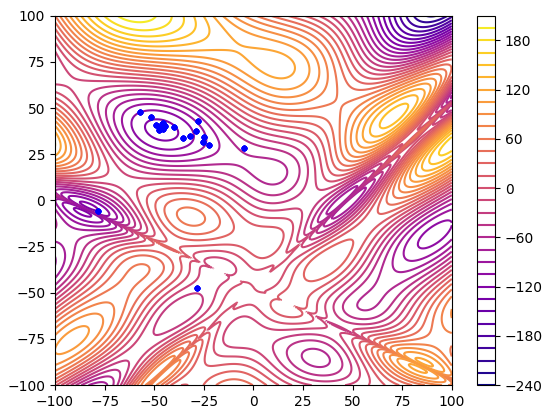

On the other hand, we could sample randomly for all function calls, and as we can see we achieved a better solution than previous as the random sampling obtained a value on the slope of the global min at the top right corner. The problem is that random sampling does not optimize towards any solution: 

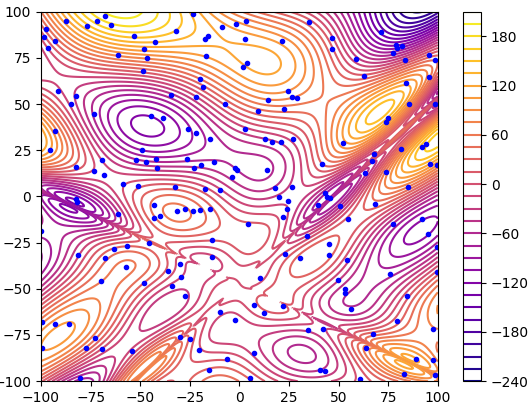

The compromise between the two is to have a large initial population to create diversity and then optimize towards the best solution in hopes that it will lead to an optimal solution. This is the goal of the differential evolution algorithm proposed here.

An initial population is created, which creates randomly generated models and then the best are taken for optimization through the algorithm. 


## Saving Weights

To speedup the training process, the weights of the convolutional kernels and batch normalizaton values are saved and loaded for each model, where the best set of weights are saved if the training loss of the model is better than previous. New models load these weights, if the dimensions are equal, and start training from there. In this way, training is sped up as the initial weights are the final weights of already converged models. 

## Evolution Process - Creating Ensemble

After the initial population has been trained, the best set of models are taken for evolution. During this process, the models are not trained until convergence, but have an even shorter leash than before. Because all the model's weights should have been saved, and the nature of the algorithm is to converge the population towards a single model, all models will be extremely similar in the end. Therefore, we only need to train with a small number of epochs for comparison.

Once the evolution process is finished, the final generation is trained on the entire dataset to create an ensemble of networks that can create confidence and validation within the population of final models.

# Load Algorithms from Evolutionary Computation Library

In [1]:
from EvolutionaryComputation.AutoML.initial_populations import NetworkInitialPopulation
from EvolutionaryComputation.AutoML.modules import CustomConvolutionModule
from EvolutionaryComputation.AutoML.modules import CustomDeepModule
from EvolutionaryComputation.AutoML.modules import hyper_param_sample
from EvolutionaryComputation.AutoML.neural_network_architecture import NetworkArchitectureEvolution

# Load Other Necessary Libraries

In [2]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.backend import clear_session
import numpy as np
import tensorflow as tf
import gc
import os
import pickle

# Data Set Example - Ciphar10

To showcase the power of the algorithm, we will test it on the cifar10 dataset. The Ciphar10 dataset is a $32x32$ pixel $3$ channel RGB image dataset containing $50,000$ training images and $10,000$ testing images. Within the dataset are $10$ unique classifications. The data images are split into three random sections: training, validation, and testing. The original training data is split into the training and validation data by an 80/20 split. The validation data is chosen randomly from the training pictures. For the entire process, the models will only be allowed to train on the training indices and perform early stopping on the validation indices, while the ensemble of networks at the end of evolution will be tested on the testing data. 
## Sample Images

![image-3.png](ciphar10.png)

In [3]:
(trainX, trainy), (testX, testy) = cifar10.load_data()
trainX = trainX.astype('float32')
testX = testX.astype('float32')
trainX = trainX / 255.0
testX = testX / 255.0

n = len(trainX)
ind = list(range(0, n))
np.random.shuffle(ind)
val_ind = int(0.8*n)  # 80/20 split

train_ind = ind[0:val_ind]
val_ind = ind[val_ind:]

# Creating Modules

For each convolution module, a convolution, pooling, activation, batch norm, and dropout layer are available. For each deep module, a dense, batch norm, and dropout layer are available.

## Convolution Modules

Below we have a function for creating a default convolution module. We create the module through the `CustomConvolutionModule` object and then add layers through their respective functions. The term `prob_include` refers to the probability of including that layer, or to the probability of including that module (if being the hyperparameter for the `CustomConvolutionModule` constructor). Much of the hyperparameters for each layer have already been filled out. However, the static values for these variables can be changed to by dynamic by adding additional paramters to the function declaration.

The purpose of this function is to create a basic module where the only difference is the `ch_prob`, the probability of a particular channel being chosen. We can call this function multiple times to obtain different modules and feed those into the algorithm. Note that the order in which the layers are added are the orientations of the actual module. So in this example, the convolution layer is first, then pooling, then activation, etc. Note, modules can hold multiple occurences of the same layer. For example, we could define 

```python
ch_prob = [0.2, 0.2, 0.2, 0.2, 0.2]  # uniform probability for channel selection
conv_module.addConvolution(channel_sizes=[32, 64, 128, 256, 512], ch_prob=ch_prob)
conv_module.addPooling(max_prob=0.50, avg_prob=0.50, prob_include=0.6)
conv_module.addConvolution(channel_sizes=[32, 64, 128, 256, 512], ch_prob=ch_prob)
conv_module.addPooling(max_prob=0.50, avg_prob=0.50, prob_include=0.6)
conv_module.addDropOut(prob_include=0.8, min_alpha=0.2, max_alpha=0.5)  # alpha is dropout percentage
```

Note that each convolution layer has no `prob_includ`, meaning that it is always included. This is performed to prevent architectures with little to no convolution layers from being designed. 

The power of designing the modules gives the user the ability to insert prior beliefs of how the architecture should be designed, thus limiting the necessity of exploring the domain space. 

The only issue that may arise is determining the probability of including pooling layers. The objective of adding pooling layers is to decrease the dimensionality of the input. The problem is that too many pooling layers will lead to an extremely small input for the deep network, while no pooling layers will lead to Memory Overload as trying to create a $32x128x128x128$ tensor, (128 channels) is not feasible. Thus, playing around with the probability of including a pooling layer before hand might be necessary. However, if the input image is large, then this might not be necessary but for this example, a 32x32 image can shrink extremely fast. The default stride length for pooling is 2x2, meaning that 32 will decrease down to 1 with 5 pooling layers. Therefore, we might need to adjust the probability of including a pooling layer so that we don't end up with more than 5-6 pooling layers. We can do this through the sampling function provided within the automl module:

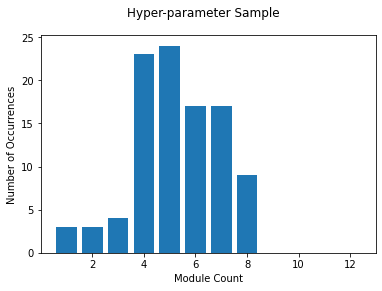

,,,,,,,,,,,,
Module Counts,1,2,3,4,5,6,7,8,9,10,11,12
Num of Occurrences,3,3,4,23,24,17,17,9,0,0,0,0


In [34]:
# define module probability - assume 12 modules with probability of 80% of being kept
mod_prob = [0.8]*12
# define hyper-param2probability - pooling in our example, - assume probability of 0.55 of being kept
pool_prob = [0.55]*12
hyper_param_sample(module_probs=mod_prob, hyper_param_prob=pool_prob, num_sample=100)

As we can see from above, the highest number of occurences occured at module count 5, meaning that from a random sample of 100 individuals, 24 of those selected to include the hyper-parameter (pooling layer in our case) in 5 of the possible 12 modules. Remember, anything more than 5 pooling layers has the same affect as the size of the image would have been reduced down to $1x1xchannel\ output$; therefore we can treat module counts 5-12 as the same. Meaning that in reality only $3+3+4+23=33$% of this random sample would have an output into the deep network greater than a $1x1xchannel\ output$ size. In this way, we could toy around with the pooling probabilities to achieve an acceptable number of occurences in a desired number of modules.


## Chromosome

The chromosome of each individual is created as follows. Suppose we are using the following module below:

```python
conv_module = CustomConvolutionModule(prob_include=0.8)
conv_module.addConvolution(channel_sizes=[16, 32, 64, 128, 256, 512], ch_prob=[0.2, 0.7, 0.1, 0, 0, 0])
conv_module.addPooling(max_prob=0.50, avg_prob=0.50, prob_include=0.55)
conv_module.addActivation(activations=['relu', 'leaky_relu', 'selu', 'elu'], activation_probs=[0.25]*4,prob_include=0.8)
conv_module.addBatchNorm(prob_include=0.8)
conv_module.addDropOut(prob_include=0.8, min_alpha=0.2, max_alpha=0.5)
```

Then the chromosome would be created as follows:

| Description: | Prob. Include Module | Channel Size | Prob Incl. Pool | Pool Type | Prob Incl. Act | Act Type | Prob Incl. Batch | Prob Incl. Drop | Alpha value |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |  
| Upper Bound | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 1 | 0.5 |
| Lower Bound | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0.2 |

Now lets generate a random individual from the bounds listed above: 

$[0.32, 0.91, 0.57, 0.55, 0.88, 0.55, 0.07, 0.08, 0.34]$

Now lets create the individual, because the value at index 0, $0.32<0.8$, the probability of inluding the module we include the current module. Next, for the convolution layer, we create a cumulative distribution from the channel probabilities, obtaining $[0.2, 0.9, 1, 1, 1]$. Now we see where the second index lies within this distribution, $0.9 < 0.91 < 1$, which lies after the second index, meaning the selected channel size is $64$. Next, because the third index is greater than the probability of including the pooling layer, $0.57>0.55$, the pooling layer is not added. We now skip over the fourth index as that was designated as a hyperparameter selection for the pooling layer. Next, the fifth index is also greater than the probability of including an activation layer, $0.88>0.8$, meaning that the activation layer is not added. We now skip over the sixth index as that was designated as a hyperparameter for the activation layer. Next, because the seventh index is less than the probability of including the Batch Norm layer, $0.07<0.8$, the Batch Norm Layer is added. Lastly, the eigth index is less than the probability of including the DropOut layer, $0.08<0.8$, therefore the dropout layer is included where the dropout percentage is determined by the hyperparameter index, index 9, which is $0.34$. Therefore, the dropout layer will have a dropout percentage of $0.34$%. In the end, the following module was created:

$Conv2D(channel=64) -> BatchNorm() -> DropOut(alpha=0.34)$

For multiple modules, the chromosome is stacked on top of each other, where if the chromosome index for a particular module is greater than the probability of including the module then all the indices for that module are skipped. The same logic can be applied for creating the chromosome of the deep network.

## Deep Modules

Below we have a function for creating a default deep module. We create the module through the `CustomDeepModule` object and then add layers through their respective functions. The same logic and reasoning from the convolution module can be applied below. 

Like the convolution layer in the convolution module, the dense layer in the deep module has no `prob_include` as it is always included within the module.

## Prior Information

Defining the module architecture allows the data scientist to insert prior beliefs about how the architecture should look like. For example, the activation function can come before or after the pooling layer as the output is still the same. However, pooling and activaiton should come before batch normalization as batch normalization normalizes the output for the next layer; therefore, it would make sense to have it be after to affect the input for the next layer. However, there is still debate on whether dropout should be placed before or after batch norm. For this example, we assume dropout is included after batch norm. 

The power of inserting prior information into how the module architectures should be designed narrows the possible architectures for the algorithm to test and to optimize, leading to more 'better' models trained. 

In [4]:
def create_conv_module(ch_prob, prob_include=0.8):   # add more parameters for choosing hyper param for each layer
    conv_module = CustomConvolutionModule(prob_include=prob_include)
    conv_module.addConvolution(channel_sizes=[16, 32, 64, 128, 256, 512], ch_prob=ch_prob)
    conv_module.addPooling(max_prob=0.50, avg_prob=0.50, prob_include=0.55)
    conv_module.addActivation(activations=['relu', 'leaky_relu', 'selu', 'elu'], activation_probs=[0.25]*4,prob_include=0.8)
    conv_module.addBatchNorm(prob_include=0.8)
    conv_module.addDropOut(prob_include=0.8, min_alpha=0.2, max_alpha=0.5)
    return conv_module

def create_deep_module():  # add parameters for choosing hyper param for each layer
    deep_module = CustomDeepModule(prob_include=0.75)
    deep_module.addDense(min_node=50, max_node=250, activations=['relu', 'leaky_relu', 'selu', 'elu'], activation_probs=[0.25]*4)
    deep_module.addBatchNorm(prob_include=0.75)
    deep_module.addDropOut(prob_include=0.75, min_alpha=0.2, max_alpha=0.5)
    return deep_module

## Fitness Function for Initial Population

As stated previously, the initial population will have a different fitness function than the evolution algorithm. The fitness function for the inital population will take in a single model, compile it, train it until convergence or callbacks, and then return the validation accuracy and loss. Each model will load pre-existing weights before training and save its final weights. To ensure that the best weights are kept, the weights of a model are only saved, overwritting pre-existing saved weights, if its validation loss is smaller than the already existing weights. Notice that the model is compiled in a try-except block, this is due to the possibility that a given model architecture may not be feasible, highly unlikely but possible. In these cases the returned validation accuracy and loss are extremely small and large to ensure that this model's weights are not saved and chosen for evolution. 

It is suggested that the initial population function is to use only $50$% of the dataset for training to get a general idea of the generality of the model and to reduce training times. Because the cifar10 dataset has $50,000$ images, $25,000$ are seleted for training and validation. The validation set should be composed of about $20$% of the seleted training data. Currently, the training and validation indices contain $40,000$ and $10,000$ images respectively. To achieve only $50$% of the dataset for training, $20,000$ images are randomly chosen from the training set of indices while only $5,000$ images are randomly chosen from the validation set.  

See below for an example on how to define the fitness function for the inital population. 


In [5]:
# fitness function to train and evaluate a given model
def fitness_function_init_pop(model, max_epoch=50):
    # callbacks based off early stopping
    callback = [EarlyStopping(monitor='loss', patience=5), EarlyStopping(monitor='val_loss', patience=5),
                EarlyStopping(monitor='val_accuracy', patience=5), TerminateOnNaN()]
    
    t_ind = np.random.choice(train_ind, 20000, replace=False)
    v_ind = np.random.choice(val_ind, 5000, replace=False)
    try:
        # compile model 
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        history = model.fit(trainX[t_ind], trainy[t_ind], batch_size=128, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(trainX[v_ind], trainy[v_ind]))
        
        f = np.nanmax(history.history['val_accuracy'])
        v = np.nanmin(history.history['val_loss'])
        
        del model  # delete model to prevent lost memory
        
    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 10000
        gc.collect()  # call gargabe collection
        clear_session()  # clear tensorflow model
        tf.compat.v1.reset_default_graph()  # clear tensorflow model
        
    return f, v

## Creating the Modules

Now it is time to create the convolution modules, to keep things simple we will create two modules per channel possibility, totalling to max 12 modules, or max 12 convolution layers. Note that each module has a probability of being included at $80$%, meaning not all models will have all twelve modules. We define a list to contain each module where the FIFO data structure ensures that the first module inersted is to be the first module in the architecture of the network. 

Because it is generally advised to grow the output channels of convolution layers, the probability of creating the respetive channel will always be one.

The deep modules are created in the same manner, appending the modules to a list. In this case we will only have two deep modules

In [6]:
conv_modules = []
conv_modules.append(create_conv_module(ch_prob=[1, 0, 0, 0, 0, 0]))  # always channel 16
conv_modules.append(create_conv_module(ch_prob=[1 ,0, 0, 0, 0, 0]))  # always channel 16
conv_modules.append(create_conv_module(ch_prob=[0, 1, 0, 0, 0, 0]))  # always channel 32
conv_modules.append(create_conv_module(ch_prob=[0 ,1, 0, 0, 0, 0]))  # always channel 32
conv_modules.append(create_conv_module(ch_prob=[0, 0, 1, 0, 0, 0]))  # always channel 64
conv_modules.append(create_conv_module(ch_prob=[0, 0, 1, 0, 0, 0]))  # always channel 64
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 1, 0, 0]))  # always channel 128
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 1, 0, 0]))  # always channel 128
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 1, 0]))  # always channel 256
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 1, 0]))  # always channel 256
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 0, 1]))  # always channel 512
conv_modules.append(create_conv_module(ch_prob=[0, 0, 0, 0, 0, 1]))  # always channel 512

In [7]:
deep_modules = []
deep_modules.append(create_deep_module())
deep_modules.append(create_deep_module())

## Running Initial Population

Now it is time to run the initial population. We pass in the convolution and deep modules, the image input shape along with the number of output nodes and output activation. In addition to these parameters, we can pass in the directory to where the weights will be saved along with the initial population size. For this example, we will create 100 randomly gnerated models.

In [8]:
init_pop = NetworkInitialPopulation(convolution_module=conv_modules, deep_module=deep_modules,
                                    init_size=100, input_shape=(32, 32, 3), save_dir='saved_weights5', 
                                    num_output=10, output_act='softmax')

In [32]:
# run the initial population and pass in the fitness function 
init_fit = init_pop.fitness(fitness_function=fitness_function_init_pop)

Model 1/100 - Expected Total Time Left: ???
   Best Model: 1 - Best: 0.65, Top 5%: 0.65, Top 10%: 0.65, Top 15%: 0.65, Top 20%: 0.65
Model 2/100 - Expected Total Time Left: 33508.8474 sec
   Best Model: 2 - Best: 0.72, Top 5%: 0.7165, Top 10%: 0.713, Top 15%: 0.7095, Top 20%: 0.706
Model 3/100 - Expected Total Time Left: 28992.1178 sec
   Best Model: 2 - Best: 0.72, Top 5%: 0.713, Top 10%: 0.706, Top 15%: 0.699, Top 20%: 0.692
Model 4/100 - Expected Total Time Left: 24376.378 sec
   Best Model: 4 - Best: 0.7348, Top 5%: 0.7326, Top 10%: 0.7304, Top 15%: 0.7281, Top 20%: 0.7259
Model 5/100 - Expected Total Time Left: 22964.5473 sec
   Best Model: 4 - Best: 0.7348, Top 5%: 0.7318, Top 10%: 0.7289, Top 15%: 0.7259, Top 20%: 0.723
Model 6/100 - Expected Total Time Left: 22965.3469 sec
   Best Model: 6 - Best: 0.7598, Top 5%: 0.7536, Top 10%: 0.7473, Top 15%: 0.741, Top 20%: 0.7348
Model 7/100 - Expected Total Time Left: 22264.743 sec
   Best Model: 6 - Best: 0.7598, Top 5%: 0.7523, Top 10%

   Best Model: 40 - Best: 0.8356, Top 5%: 0.8046, Top 10%: 0.7929, Top 15%: 0.7793, Top 20%: 0.775
Model 55/100 - Expected Total Time Left: 14756.692 sec
   Best Model: 40 - Best: 0.8356, Top 5%: 0.8041, Top 10%: 0.7926, Top 15%: 0.7789, Top 20%: 0.7747
Model 56/100 - Expected Total Time Left: 14299.0312 sec
   Best Model: 40 - Best: 0.8356, Top 5%: 0.8036, Top 10%: 0.7922, Top 15%: 0.7803, Top 20%: 0.7758
Model 57/100 - Expected Total Time Left: 13873.0246 sec
   Best Model: 40 - Best: 0.8356, Top 5%: 0.8031, Top 10%: 0.7918, Top 15%: 0.78, Top 20%: 0.7755
Model 58/100 - Expected Total Time Left: 13567.9109 sec
   Best Model: 40 - Best: 0.8356, Top 5%: 0.8026, Top 10%: 0.7915, Top 15%: 0.7798, Top 20%: 0.7752
Model 59/100 - Expected Total Time Left: 13107.7062 sec
   Best Model: 40 - Best: 0.8356, Top 5%: 0.802, Top 10%: 0.7911, Top 15%: 0.7796, Top 20%: 0.775
State Save: state_save_init_pop60
Model 60/100 - Expected Total Time Left: 12797.4309 sec
   Best Model: 40 - Best: 0.8356, To

### Save Initial Population

In [34]:
#pickle.dump(init_pop, open("init_pop", "wb"))
init_pop = pickle.load(open("init_pop", "rb"))

## Plot Results
As we can see from the results, the best model achieved a validation accuracy of $0.8356$, not bad for only being trained on half the dataset. We can see that the top $5$% of models had an average of $0.80$% accuracy, while the top $20$% of models had an average accuracy of $0.776$%. 

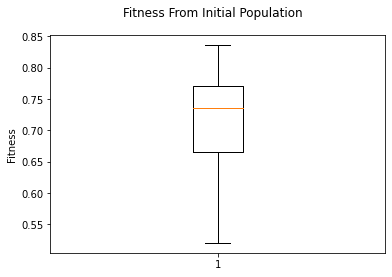

In [37]:
init_pop.plot()

# Fitness Function for Evolution

Now since we've finished running the initial population, it is time for evolution. For this part we need to redefine another fitness function. This fitness function will be the same as before except the leash on training will be much shorter. Because the evolution algorithm will only take the best models from the initial population, the fact that the final weights of the best models are saved, and the algorithm will eventually converge around a single model, the training time will be much shorter, only 10 epochs will a patience of 3 epochs for early stopping. This is performed to speed up training and evaluation times.

In [9]:
def fitness_function_evolution(model, max_epoch=10):
    callback = [EarlyStopping(monitor='loss', patience=3), EarlyStopping(monitor='val_loss', 
                                                                         patience=3),
                EarlyStopping(monitor='val_accuracy', patience=3)]
    
    t_ind = np.random.choice(train_ind, 20000, replace=False)
    v_ind = np.random.choice(val_ind, 5000, replace=False)
    try:
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
 
        history = model.fit(trainX[t_ind], trainy[t_ind], batch_size=128, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(trainX[v_ind], trainy[v_ind]))
        f = np.nanmax(history.history['val_accuracy'])
        v = np.nanmin(history.history['val_loss'])
        del model
    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 1000
    gc.collect()
    clear_session()
    tf.compat.v1.reset_default_graph()
    return f, v

# Running Differential Evolution Algorithm
The algorithm will take in the generation size, $15$ in this case, and select the best $10$ individuals from the initial population and perform evolution. With a max iter of $25$, $15*25=300$ models shall be created and tested. 

In [10]:
network_evolve = NetworkArchitectureEvolution(initial_population=init_pop, gen_size=15)

In [45]:
network_evolve.evolve(find_max=True, max_iter=25, state_save=5, fitness_function=fitness_function_evolution)

Initial Generation : 
  Best Fit: 0.8356000185012817, Mean Fit: 0.7983733375867208, Worst Fit: 0.7806000113487244
Generation 0 - Model 15/15 - Expected Total Time Left: 58554.2009 sec
  Best Fit: 0.8370000123977661, Mean Fit: 0.8072800040245056, Worst Fit: 0.7904000282287598
Generation 1 - Model 15/15 - Expected Total Time Left: 56285.1343 sec
  Best Fit: 0.842199981212616, Mean Fit: 0.8154933333396912, Worst Fit: 0.7993999719619751
Generation 2 - Model 15/15 - Expected Total Time Left: 65116.8621 sec
  Best Fit: 0.854200005531311, Mean Fit: 0.8328533331553142, Worst Fit: 0.8127999901771545
Generation 3 - Model 15/15 - Expected Total Time Left: 67212.4962 sec
  Best Fit: 0.8611999750137329, Mean Fit: 0.8459999958674113, Worst Fit: 0.8342000246047974
Generation 4 - Model 15/15 - Expected Total Time Left: 68234.4202 sec
  Best Fit: 0.8636000156402588, Mean Fit: 0.8542933344841004, Worst Fit: 0.8428000211715698
State Save: state_save_evolution4
Generation 5 - Model 15/15 - Expected Total 

### Save Network

In [9]:
#pickle.dump(network_evolve, open("network_evolve", "wb"))
network_evolve = pickle.load(open("state_save_evolution21", "rb"))['obj']
network_evolve

# Plot Results
Now that the algorithm has converged, it is time to evaluate the results. 

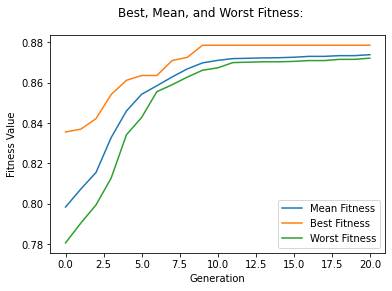

In [10]:
network_evolve.plot_evolution()

# Fitness Function for Ensemble
As stated before, once the evolution process has concluded, the final generation needs to be trained on the entire dataset, until convergence, to create the final set of ensemble models. 

In [11]:
def fitness_function_final(model, max_epoch=20):
    callback = [EarlyStopping(monitor='loss', patience=3), EarlyStopping(monitor='val_loss', patience=3),
                EarlyStopping(monitor='val_accuracy', patience=3)]
    try:
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      metrics=['accuracy'])
        history = model.fit(trainX[train_ind], trainy[train_ind], batch_size=128, epochs=max_epoch,
                            verbose=0, callbacks=callback,
                            validation_data=(trainX[val_ind], trainy[val_ind]))
        f = np.nanmax(history.history['val_accuracy'])
        v = np.nanmin(history.history['val_loss'])
        del model
    except Exception as e:
        print("Model Architecture Failure")
        print(e)
        f = -1
        v = 1000
    gc.collect()
    clear_session()
    tf.compat.v1.reset_default_graph()
    return f, v

# Create Ensemble

In [12]:
network_evolve.create_ensemble(fitness_function=fitness_function_final, find_max=True)

Model 1/15 - Expected Total Time Left: ???
Best Model: 1, Best: 0.9404000043869019, Mean: 0.9404000043869019, Worst: 0.9404000043869019
Model 2/15 - Expected Total Time Left: 2813.2056 sec
Best Model: 1, Best: 0.9404000043869019, Mean: 0.940200001001358, Worst: 0.9399999976158142
Model 3/15 - Expected Total Time Left: 2609.7268 sec
Best Model: 3, Best: 0.9412000179290771, Mean: 0.9405333399772644, Worst: 0.9399999976158142
Model 4/15 - Expected Total Time Left: 2415.1138 sec
Best Model: 3, Best: 0.9412000179290771, Mean: 0.939175009727478, Worst: 0.9351000189781189
Model 5/15 - Expected Total Time Left: 2319.2438 sec
Best Model: 3, Best: 0.9412000179290771, Mean: 0.936900007724762, Worst: 0.9277999997138977
Model 6/15 - Expected Total Time Left: 2087.0007 sec
Best Model: 3, Best: 0.9412000179290771, Mean: 0.9375833372275034, Worst: 0.9277999997138977
Model 7/15 - Expected Total Time Left: 1867.3151 sec
Best Model: 3, Best: 0.9412000179290771, Mean: 0.9358714308057513, Worst: 0.92559999

## Plot Ensemble Results

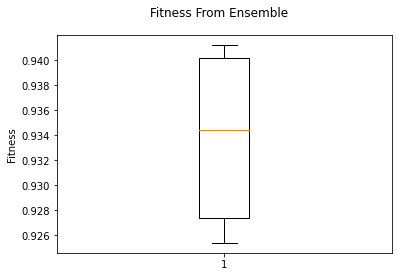

In [13]:
network_evolve.plot_ensemble()

As we can see from above, our ensemble has very good validation accuracies, ranging from $94$% to $92.5$% accuracy on the entire validation set. 

## Test Ensemble
For evaluating the ensemble, there are two main functions, `ensemble_predict` which returns the raw output from the output layers and `ensemble_predict_classes` which takes the argmax of the output. There are three methods for predicting, `sum`, `mean` and `median`. The `sum` takes the sum of the output from each model, while `mean` and `median` take the mean and median from the output from each layer. The argmax from the final sum, mean, or median is then calculated to formulate the final output.

In [14]:
preds = network_evolve.ensemble_predict(testX, method='sum')

In [15]:
classes = network_evolve.ensemble_predict_classes(testX, method='sum')

# Conclusion

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(testy, classes)

0.8909

As we can see, our final ensemble achieved an accuracy score of $89.09$% from the testing set. Although this is not the highest accuracy score achieved by the algorithm, as previous unsaved runs achieved $91.56$%, it is still acceptable.

# Plotting Models
To see the difference between the best model from the initial population and the one of the final models of the ensemble, check out the pictures below:

In [49]:
from tensorflow.keras.utils import plot_model

In [55]:
cnn = init_pop.init_pop_convolution[:, bst, :].flatten()
deep = init_pop.init_pop_deep[:, bst, :].flatten()
bst_init_model = network_evolve.create_model(cnn=cnn, deep=deep, output_act=network_evolve.output_act, 
                                             num_output=network_evolve.num_output)

## Best Initial Population Model

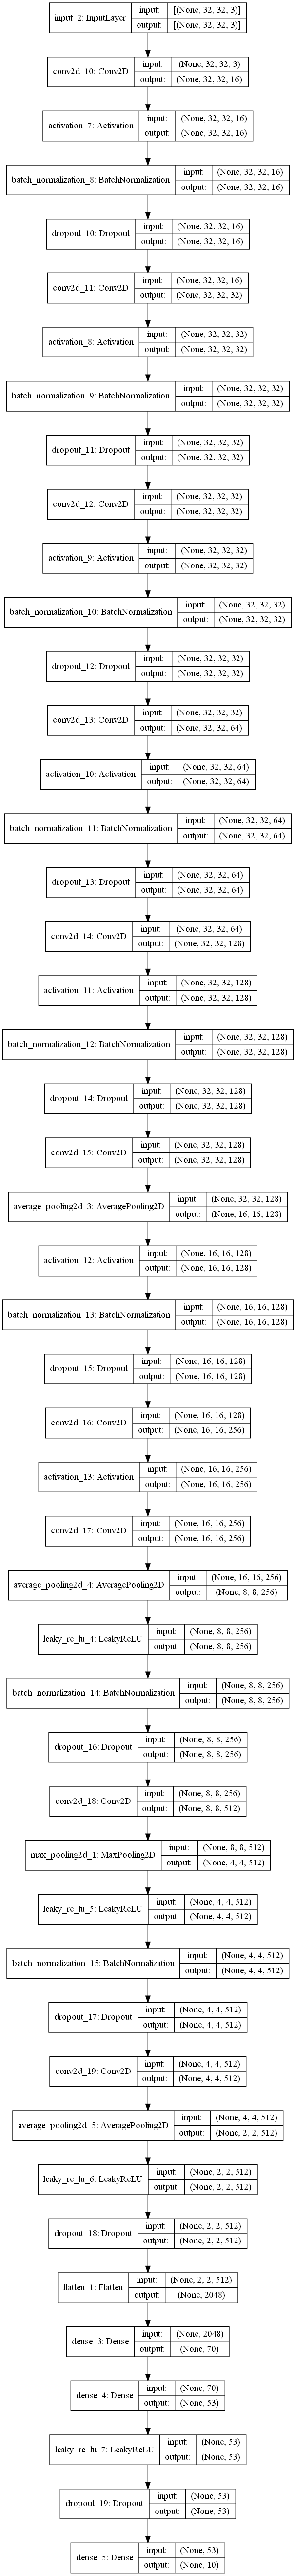

In [56]:
plot_model(bst_init_model, show_shapes=True, to_file="best_init_pop_model.png")

## First Ensemble Model

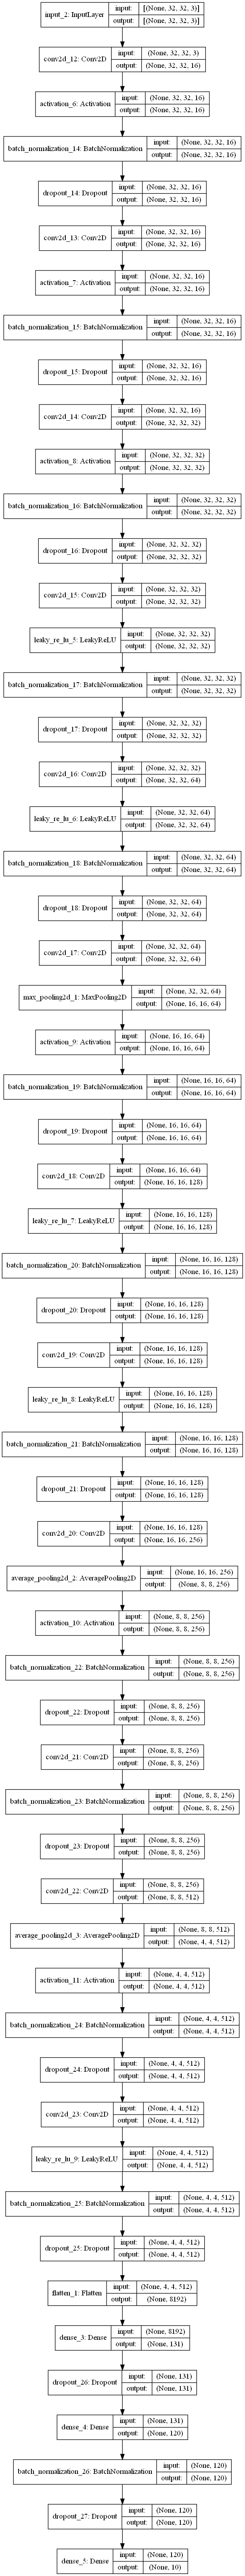

In [52]:
plot_model(network_evolve.ensemble[0], show_shapes=True, to_file="ensemble_model1.png")